In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from retinanet import coco_eval
from retinanet import csv_eval
from retinanet import model
from retinanet import paps_eval
from retinanet import paps_train

# from retinanet import retina
from retinanet.dataloader import *
from retinanet.anchors import Anchors
from retinanet.losses import *
from retinanet.scheduler import *
from retinanet.hourglass import hg1, hg2, hg8
from retinanet.parallel import DataParallelModel, DataParallelCriterion

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam, lr_scheduler
import torch.optim as optim


In [2]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(img, bbox, cla, color=BOX_COLOR, thickness=1):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = list(map(int, bbox))
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
    if int(cla) == 1 :
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    else :
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255,255,0), thickness=thickness)
    return img

def visualize(image, bboxes, classes):
    img = image.copy()
#     img = image.clone().detach()
    for bbox, cla in zip(bboxes, classes):
#         print(bbox)
        img = visualize_bbox(img, bbox, cla)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [3]:
device = torch.device('cpu')
# device = torch.device('cuda')
model = hg2(device, pretrained=True, progress=False, num_classes=2)
# model.to(device)

num_classes 2


In [4]:
saved_dir = '../trained_models/HourGlass/loss_filter1/'
e_epoch=120
if os.path.isfile(saved_dir + 'epoch_' + str(e_epoch) +'_model.pt') :
    print('pretrainind file loading')
    state = torch.load(saved_dir + 'epoch_' + str(e_epoch) +'_model.pt')
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'], strict=False)
#     optimizer.load_state_dict(state['optimizer'])
    last_loss = state['loss']
else :
    last_loss = 0.6

pretrainind file loading


In [5]:
dataset_val = PapsDataset('../data/', set_name='val_2class',
                            transform=val_transforms)

val_data_loader = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [42]:
model.training = False

for index, data in enumerate(tqdm(val_data_loader)) :
    with torch.no_grad():        
        images, tbox, tlabel, targets = data
        print(images[0].shape)
        print('targets', targets)
        batch_size = len(images)

        c, h, w = images[0].shape
        images = torch.cat(images).view(-1, c, h, w).to(device)

        outputs = model(images)
        scores, labels, boxes = (outputs)
#         print('scores', scores)
#         print(labels)
#         print(boxes)

        scores = scores.cpu()
        labels = labels.cpu()
        boxes  = boxes.cpu()  

#         scores_list.append(scores)

        if boxes.shape[0] > 0:
            # change to (x, y, w, h) (MS COCO standard)
            boxes[:, 2] -= boxes[:, 0]
            boxes[:, 3] -= boxes[:, 1]
            
    break

  0%|          | 0/3739 [00:00<?, ?it/s]

torch.Size([3, 320, 320])
targets (tensor([[152.5000, 112.5000, 168.0000, 131.7500,   0.0000],
        [162.0000,  94.2500, 181.5000, 118.2500,   0.0000],
        [184.7500,  84.7500, 201.5000, 104.2500,   0.0000],
        [175.7500, 121.0000, 194.0000, 140.5000,   0.0000],
        [210.5000, 123.5000, 227.0000, 141.5000,   0.0000],
        [208.0000, 154.7500, 228.7500, 180.7500,   0.0000],
        [207.5000, 188.5000, 225.7500, 211.7500,   0.0000],
        [228.7500, 178.2500, 246.5000, 199.0000,   0.0000],
        [247.0000, 193.2500, 263.7500, 213.7500,   0.0000],
        [224.7500, 206.0000, 244.7500, 224.5000,   0.0000],
        [248.2500, 230.2500, 266.5000, 251.5000,   0.0000],
        [225.7500, 239.7500, 246.0000, 263.0000,   0.0000],
        [249.0000, 253.7500, 269.0000, 276.2500,   0.0000],
        [286.2500, 101.0000, 304.2500, 121.0000,   0.0000],
        [262.5000, 124.2500, 283.2500, 143.2500,   0.0000],
        [288.2500, 136.7500, 302.5000, 156.2500,   0.0000]]),)


  0%|          | 0/3739 [00:02<?, ?it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([320, 320, 3])


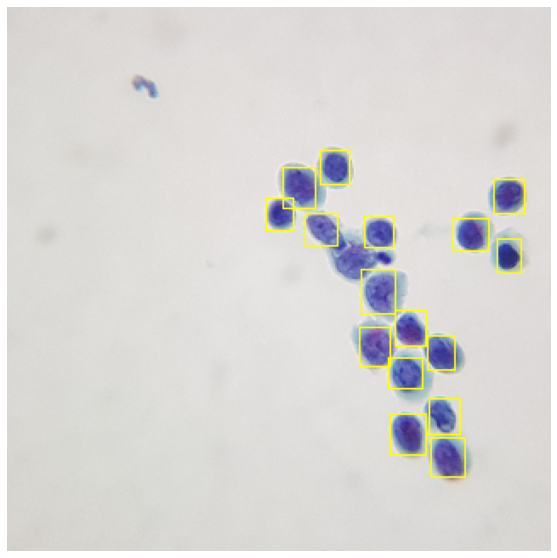

In [43]:
image = images.squeeze()
image = torch.transpose(image, 0, 1)
image = torch.transpose(image, 1, 2)
print(image.shape)
visualize(image.numpy(), targets[0][:,:4], targets[0][:,4])

tensor([0.2391, 0.2296, 0.2268, 0.2206, 0.2003, 0.1560, 0.1550, 0.1399, 0.0959,
        0.0614, 0.0504])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


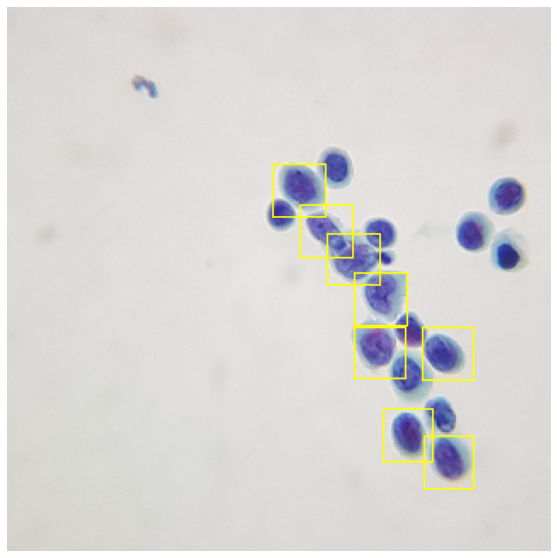

In [44]:
boxes[:, 2] += boxes[:, 0]
boxes[:, 3] += boxes[:, 1]

pred_box = []
for s,b in zip(scores, boxes) :
    if s > 0.1 :
        pred_box.append(b)
print(scores)    
visualize(image.numpy(), pred_box, labels)

In [46]:
saved_dir + 'val_2class_GTbbox_results.json'

'../trained_models/HourGlass/loss_filter1/val_2class_GTbbox_results.json'

In [54]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# annType = 'bbox'

# cocoGt=COCO(saved_dir + 'val_2class_GTbbox_results.json')
# cocoDt=cocoGt.loadRes(saved_dir + 'val_2class_bbox_results.json')
coco_true = dataset_val.coco
coco_pred = coco_true.loadRes(saved_dir + '{}_bbox_results.json'.format(dataset_val.set_name))
coco_gt = coco_true.loadRes(saved_dir + '{}_GTbbox_results.json'.format(dataset_val.set_name))


# running evaluation
cocoEval = COCOeval(coco_gt,coco_pred,annType)
cocoEval.params.imgIds = 1
cocoEval.params.iouThrs = [.4]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | m

In [52]:
cocoEval.params.iouThrs

<bound method Params.setDetParams of <pycocotools.cocoeval.Params object at 0x7f70e72cd6d0>>